In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import kstest

from scipy import interpolate

import pandas as pd


from funcs.ad import sample_AD_for_custom_distribution, get_pvalue_from_AD_statistic
from funcs.helper import get_tess_orbital_phases, get_cheops_orbital_phases

# set default matplotlib fontsize to 13
plt.rcParams.update({'font.size': 13})

def get_observed_phases(p, lcs, cadences, qcs, phaseshift=0.):
    """Takes 
    
    ps, bins = get_observed_phases(np.sort(pss), lcs, [2,2,2,10./60.], [11, 38, 64,1], phaseshift=phaseshift)#

    
    Parameters:
    -----------
    mode : str
        either "Rotation" or "Orbit"
    p : array
        array of phases, for the KS-test it should be the 
        measured flare phases, for the AD test, any well 
        sampled grid of phases works
    phaseshift : float
        default = 0
        
    Return:
    -------
    pandas.DataFrame - one column per Sector or Quarter,
                       and observing time per phase in each row
    list - mids of bins for each phase row in the DataFrame
    """
    
    # bin array is two elements longer than the number of bins
    # to include 0 and 1
    bins = p 
    # add zero and one
    bins = np.concatenate([bins, [1]])
    bins = np.concatenate([[0], bins])
#     print(bins)
    phases = pd.DataFrame()
#     plt.figure(figsize=(8, 3))
    for q, cadence, ph in list(zip(qcs, cadences, lcs)):
        

        counts, bins = np.histogram((ph + phaseshift) % 1, bins=bins)
            
        # get observing times for each Sector
        phases[q] = counts * cadence
    print(phases)

    return phases, (bins[1:] + bins[:-1])/2



def get_cumulative_distributions(df, dfphases, sectors, F_k_cheops):
    """Calculate the cumulative distribution function of observed
    flares, while accounting for the number of observed flares in
    a light curve with a given detection threshold.

    Parameters:
    -----------
    df : DataFrame
        detected flares table, with a flag qcs that denotes the LC
    dfphases : DataFrame
        table that lists the observed phases, with a column for each LC
    get_secs_cadences : list
        format: [(Sector, cadence in minutes), (.., ..), (.., ..)]
        Sector is an int
        cadence is a float
    """
    # Measured number of flares in each bin
    F = dfphases.shape[0]
    n_i = np.full(F, 1)

    # Calculate cumulative frequency distribution
    cum_n_i = np.cumsum(n_i) / F

    # Expected number of flares in each bin

    # setup array for each bin
    n_exp = np.zeros_like(n_i).astype(float)

    # sum over different sectors to account for different detection thresholds
    for sec in sectors:
        obstimes_k = dfphases[sec]
        # print(obstimes_k)
        tot_obstimes_k = obstimes_k.sum() # total observation time in that Sector in minutes
        # print(tot_obstimes_k)
        if sec == 1:
            F_k = F_k_cheops
        else:   
            F_k = df[df.qcs==sec].shape[0] # number of flares in that Sector


        # print(F_k)
        n_exp_k = (obstimes_k * F_k / tot_obstimes_k).values 
        # print(n_exp_k)
        n_exp += n_exp_k
        # print(n_exp)
    # for debugging: 
    # calculate the old cumulative distribution that 
    # ignores the different detection thresholds
    # cum_n_exp_alt = dfphases.sum(axis=1).values.cumsum() / dfphases.sum(axis=1).values.sum()
    
    # Calculate cumulative frequency distribution
    cum_n_exp = n_exp.cumsum() / n_exp.sum()
    
    return n_i, n_exp, cum_n_exp, cum_n_i#, cum_n_exp_alt return alternative only if necessary


In [19]:
# GET STELLAR AND PLANET PARAMETERS -----------------------------------------------------

hip67522params = pd.read_csv("../data/hip67522_params.csv")

period = hip67522params[hip67522params.param=="orbper_d"].val.values[0]
midpoint = hip67522params[hip67522params.param=="midpoint_BJD"].val.values[0]
teff = hip67522params[hip67522params.param=="teff_K"].val.values[0]
tefferr = hip67522params[hip67522params.param=="teff_K"].err.values[0]
radius = hip67522params[hip67522params.param=="radius_rsun"].val.values[0]
radiuserr = hip67522params[hip67522params.param=="radius_rsun"].err.values[0]

# ----------------------------------------------------------------------------------------

# GET OBSERVED CHEOPS PHASES --------------------------------------------------------------

cheops_phases, _, _, tot_obs_time_d_cheops = get_cheops_orbital_phases(period, midpoint, split=0.1)

# ----------------------------------------------------------------------------------------

# GET CHEOPS FLARES ----------------------------------------------------------------------

cheopsflares = pd.read_csv("../results/cheops_flares.csv")
cheopsflares["phase"] = ((cheopsflares.t_peak_BJD - midpoint) % period) / period

# ----------------------------------------------------------------------------------------

# GET OBSERVED TESS PHASES ---------------------------------------------------------------

tess_phases = get_tess_orbital_phases(period, split=0.1, by_sector=True)

# ----------------------------------------------------------------------------------------

# GET TESS FLARES ------------------------------------------------------------------------

df = pd.read_csv("../data/hip67522_tess_flares.csv")

# ----------------------------------------------------------------------------------------


/home/ilin/Documents/2024_03_HIP67522_CHEOPS/scripts/funcs/helper.py:46: LightkurveDeprecationWarning: The search_lightcurvefile function is deprecated and may be removed in a future version.
        Use search_lightcurve() instead.
  lcs = lk.search_lightcurvefile("HIP 67522", mission="TESS",author="SPOC", exptime=120)


In [20]:


# COMBINE ALL OBSERVED PHASES ------------------------------------------------------------

lcs = tess_phases.copy()
lcs.append(np.sort(cheops_phases))

# ----------------------------------------------------------------------------------------

lcs

[array([0.68294916, 0.68314873, 0.6833483 , ..., 0.92230819, 0.92250775,
        0.92270732]),
 array([0.98277603, 0.9829756 , 0.98317517, ..., 0.76213709, 0.76233665,
        0.76253621]),
 array([0.59411142, 0.59431099, 0.59451057, ..., 0.14629242, 0.14649199,
        0.14669156]),
 array([5.12830860e-06, 1.17900681e-05, 1.34396353e-05, ...,
        9.99988456e-01, 9.99995117e-01, 9.99996768e-01])]

      11     38     64           1 
0    346    714    718  1205.833333
1    154    312    310   700.000000
2     82    160    162   380.666667
3    220    442    440   998.166667
4     88    182    180   405.333333
5    228    450    452  1065.666667
6     24     46     48   120.666667
7     96    200    196   427.000000
8   1018   2028   2034  1913.666667
9    754   1510   1468     0.000000
10   992   1980   1486     0.000000
11  8198  16514  11732  2507.500000
12  2830   4668   4590   110.000000
13  2842   1946   3270   765.666667
14  4532   3542   5496   476.833333
15   144    222    298   204.833333
16   848   1492   1754  1209.666667
Obs time
11    23396.0
38    36408.0
64    34634.0
1     12491.5
dtype: float64


100%|██████████| 20000/20000 [00:14<00:00, 1344.26it/s]


20000 (20000,)
0.0022999999999998976 6.121759448096579
KstestResult(statistic=0.4135632985055265, pvalue=0.0026657959725992024, statistic_location=0.20031472523284866, statistic_sign=1)


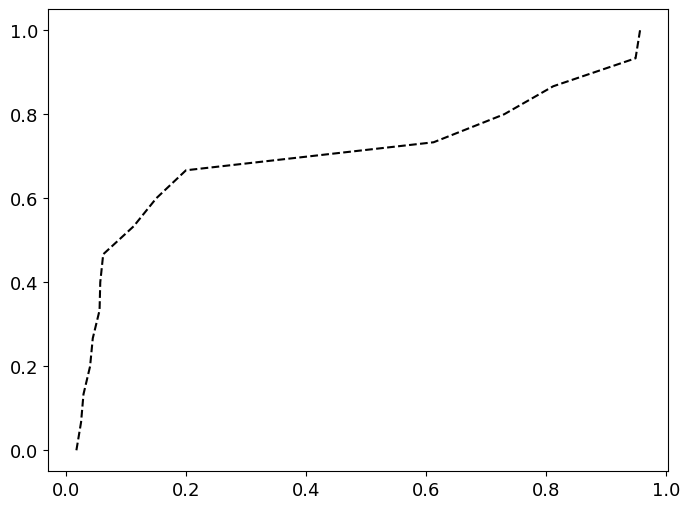

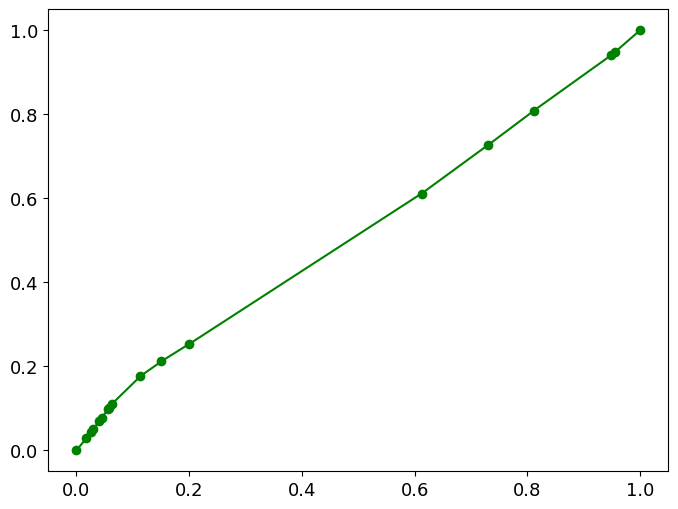

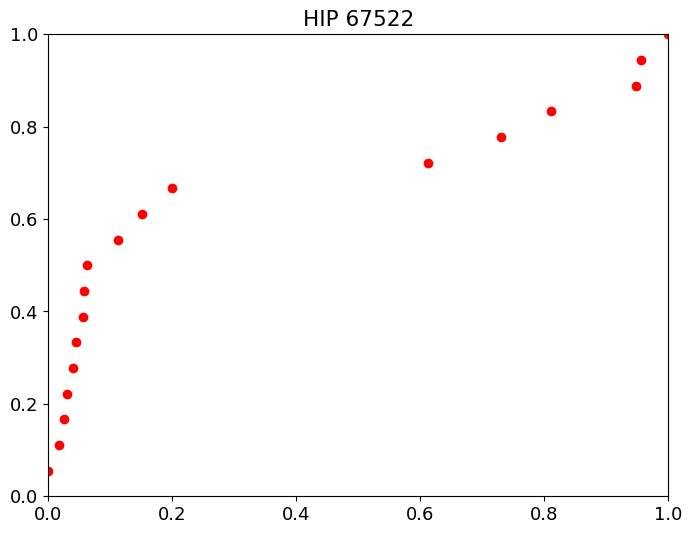

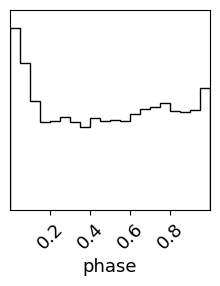

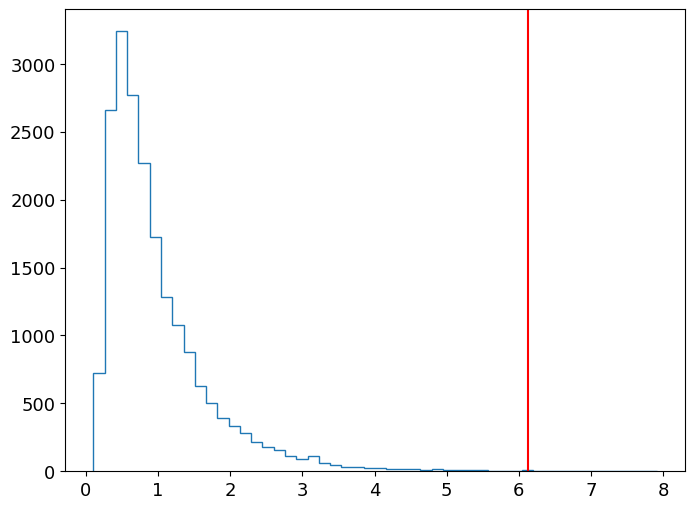

In [21]:

# RUN AD AND KS TESTS -------------------------------------------------------------------

# TESS FLARES
tessps = ((df.tstart + 2457000 - midpoint + period ) % period / period ).values
tesslc = df.qcs.values

# CHEOPS FLARES
cheopsps = cheopsflares["phase"].values
cheopslc = [1,1,1,1]

# combine the flares
pss = np.concatenate([tessps, cheopsps])
lcc = np.concatenate([tesslc, cheopslc])

# sort the phases and get observed phases
ps, bins = get_observed_phases(np.sort(pss), lcs, [2,2,2,10./60.], [11, 38, 64,1])

# calculate the expected number of flares in the CHEOPS data based on TESS data
F_k_cheops = 12 / ps[[11, 38, 64]].sum().sum() * ps[1].sum()

# sum ps in each lc
print("Obs time")
print(ps.sum(axis=0))

# init dataframe 
df = pd.DataFrame({"phases": pss, "qcs": lcc})

# get the cumulative distributions
n_i, n_exp, cum_n_exp, cum_n_i = get_cumulative_distributions(df, ps, [11, 38, 64, 1], F_k_cheops=F_k_cheops)

# plot the cumulative distribution
plt.figure(figsize=(8,6))
plt.plot(np.sort(pss), np.linspace(0,1,len(pss)), "k--")
plt.savefig(f"../plots/adtest/measured_cumhist.png")

# complete the cumulative distribution with 0 and 1 for the AD test
p = np.sort(pss)
p = np.insert(p,0,0)
p = np.append(p,1)

cum_n_exp = np.insert(cum_n_exp, 0, 0)
cum_n_i = np.insert(cum_n_i, 0, 0)

plt.figure(figsize=(8,6))
plt.plot(p, cum_n_exp, "o", color="green")
plt.savefig(f"../plots/adtest/expected_cumhist.png")

# plt.plot(p, cum_n_i, "o", color="red")

f = interpolate.interp1d(p, cum_n_exp, fill_value="extrapolate")
ph = np.linspace(0,1,1000)
plt.plot(ph, f(ph), c="green")


N =20000
# Make a diagnostic plot
plt.figure(figsize=(8,6))

# plt.plot(p,f(p), c="green")
dsave = pd.DataFrame({"p":p, "f":f(p)})
dsave.to_csv(f"../results/adtest/cumhist.csv",
                index=False)
cumsum =  np.cumsum(np.ones_like(p)) / len(p)
plt.scatter(p, cumsum, c="r")
plt.title(f"HIP 67522")
plt.xlim(0,1)
plt.ylim(0,1)
plt.savefig(f"../plots/adtest/cumhist.png")
# plt.close()

# Finally, run the A-D test
A2 = sample_AD_for_custom_distribution(f, p.shape[0], N)

# This should go into the function above
# select only the finite values
print(np.isfinite(A2).sum(), A2.shape)
A2 = A2[np.isfinite(A2)]

plt.figure(figsize=(8,6))   
plt.hist(A2, bins=50, histtype="step")

# Calculate the p-value and A2 value using the distribution 
# of A2 values
pval, atest = get_pvalue_from_AD_statistic(p, f, A2)
plt.axvline(atest, color="red")
plt.savefig(f"../plots/adtest/adtest.png")
print(pval, atest)

ks = kstest(p, f, args=(), N=1000, alternative='two-sided', mode='approx')
print(ks)


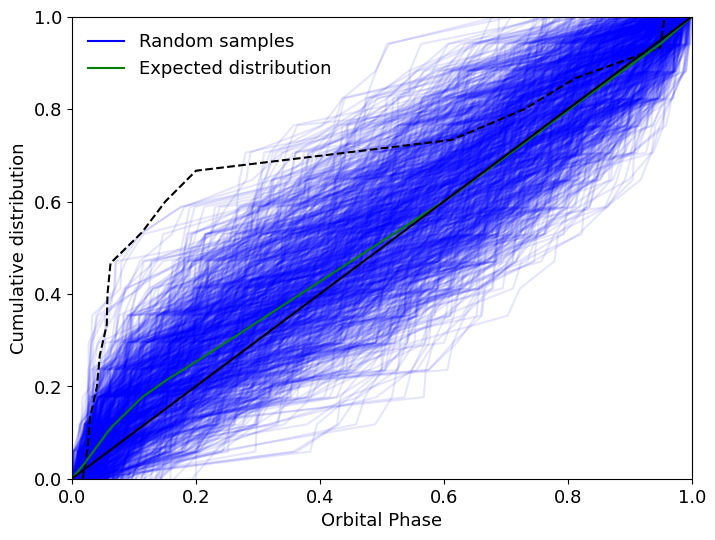

In [22]:
# read samples.npy
samples = np.load("samples.npy")

samples.shape

# plot a random subset of the samples as a cumulative histogram
plt.figure(figsize=(8,6))
for i in range(1000):
    plt.plot(np.sort(samples[i]), np.linspace(0,1,len(samples[i])), alpha=0.1, color="blue")
plt.plot(np.sort(pss), np.linspace(0,1,len(pss)), "k--")

# plot f(p) as a green line 
f = interpolate.interp1d(p, cum_n_exp, fill_value="extrapolate")
ph = np.linspace(0,1,1000)
plt.plot(ph, f(ph), c="green")

# plot the 1-1 line
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100), "k")

plt.xlim(0,1)
plt.ylim(0,1)

plt.ylabel("Cumulative distribution")
plt.xlabel("Orbital Phase")

# make legend handles with 1D line objects
import matplotlib.lines as mlines
blue_line = mlines.Line2D([], [], color='blue', label='Random samples')
green_line = mlines.Line2D([], [], color='green', label='Expected distribution')
black_line = mlines.Line2D([], [], color="k", label="1-1 line")
plt.legend(handles=[blue_line, green_line], frameon=False)

plt.savefig(f"../plots/adtest/samples_cumhist.png")